In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

from sklearn.model_selection import train_test_split
import catboost
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

**Get Stored Var**

In [2]:
%store -r df_fe
df_fe.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,lux_brand,antique
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi,1,0
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi,1,0
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi,1,0
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi,1,0
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi,1,0


In [3]:
%store -r best_param
best_param

{'depth': 9.0, 'learning_rate': 0.12010440689306091}

# Model-Based Testing

Sekarang kita akan mengintepretasi model kita menggunakan data test. Tetapi sebelumnya kita akan menguji data test kita terhadap model benchmark dan model terbaik yang sudah kita peroleh untuk melihat perbedaan sebelum dan sesudahnya.

In [4]:
x = df_fe.drop(columns=['price'])
y = df_fe['price']

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    random_state=2020
)

## Model Benchmark

In [5]:
cat_features=['model', 'transmission', 'fuelType', 'brand']
model_benchmark = CatBoostRegressor(random_state=2020, silent=True, cat_features=cat_features)
model_benchmark.fit(x_train, y_train)

In [6]:
y_pred_benchmark = model_benchmark.predict(x_test)
mae_benchmark = mean_absolute_error(y_test, y_pred_benchmark)
mape_benchmark = mean_absolute_percentage_error(y_test, y_pred_benchmark) * 100
print('MAE Score Benchmark:', mae_benchmark)
print('MAPE Score Benchmark:', mape_benchmark)

MAE Score Benchmark: 1266.4012721154463
MAPE Score Benchmark: 7.874010892766181


## Best Model

In [7]:
model_best = CatBoostRegressor(random_state=2020, silent=True, cat_features=cat_features, depth=best_param['depth'], learning_rate=best_param['learning_rate'])
model_best.fit(x_train, y_train)


In [8]:
y_pred_best = model_best.predict(x_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
mape_best = mean_absolute_percentage_error(y_test, y_pred_best) * 100
print('MAE Score Best:', mae_best)
print('MAPE Score Best:', mape_best)

MAE Score Best: 1129.7499505062651
MAPE Score Best: 6.995975378833018


Dapat terlihat, nilai MAE menjadi lebih kecil pada model terbaik yang sudah kita dapatkan dari 1266,4 menjadi 1129,75 bisa dibilang persentase kesalahah prediksi menurun dari 7.87% menjadi 7%





# Model Performance Based on Car Brand

Berikut ini kita akan menguji perfomance model kita terhadap masing-masing brand untuk mengetahui brand yang manakah yang dapat diprediksi dengan sangat baik oleh model kita dibanding brand lainnya.

In [92]:
brands = df_fe['brand'].unique()
mae_score = []
mape_score = []
for i in brands:
    x_test_brand = x_test[x_test['brand'] == i]
    brand_index = x_test_brand.index
    y_test_brand = y_test.loc[brand_index]
    
    y_pred_brand = model_best.predict(x_test_brand)
    mae_score.append(mean_absolute_error(y_test_brand, y_pred_brand))
    mape_score.append(mean_absolute_percentage_error(y_test_brand, y_pred_brand) * 100)

brandComparison=pd.DataFrame({
    'brands': brands,
    'mae_score': mae_score,
    'mape_score': mape_score,
})
brandComparison.sort_values('mape_score', ascending=True)

,brands,mae_score,mape_score
6,toyota,711.472528,6.189919
4,hyundi,884.408666,6.576604
2,merc,1629.725471,6.956348
7,vauxhall,702.081976,6.959597
8,vw,1091.707561,6.987889
3,ford,831.413698,7.034002
0,audi,1507.798921,7.148461
1,bmw,1623.225794,7.207467
5,skoda,991.360535,7.620702


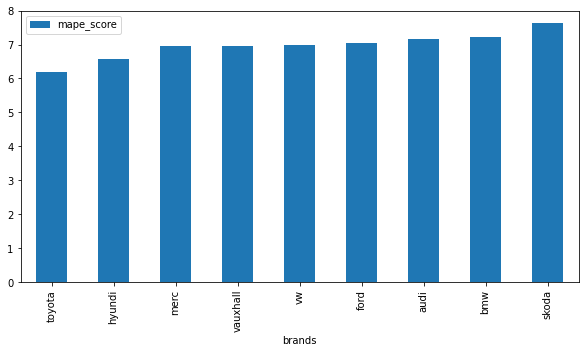

In [104]:
brandComparison[['brands', 'mape_score']].set_index('brands').sort_values('mape_score', ascending=True).plot(kind='bar', figsize=(10,5))
plt.show()

Jika kita hitung nilai MAE & MAPE per brand mobilnya, didapatkan performa terbaik pada saat memprediksi harga mobil untuk brand toyota dengan kesalahan prediksi sebesar 6.18%. Sedangkan terlihat performa yang kurang baik pada saat memprediksi mobil untuk brand skoda.

# Model Interpretation

In [9]:
explainer = shap.Explainer(model_best)
shap_values = explainer(x_test)

## Variable Importance Plot

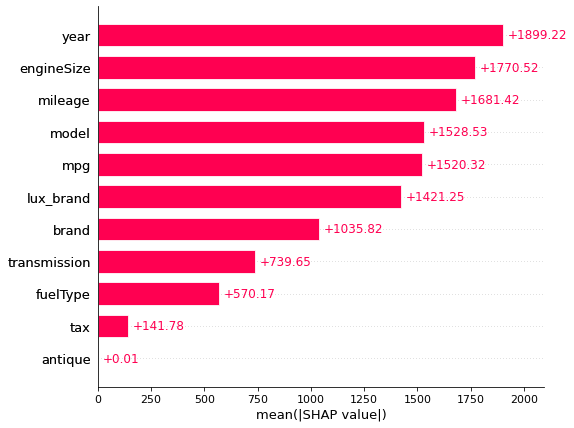

In [10]:
shap.plots.bar(shap_values, max_display=12)

Graphic diatas menunjukkan urutan fitur dari variable yang paling signifikan ke yang paling tidak signifikan dalam mempengaruhi harga sebuah mobil. Variabel paling pertama, yaitu year, adalah variable yang memiliki daya prediksi paling tinggi dibanding fitur lainnya dengan daya prediksi sebesar 1899,22. Sedangkan antique adalah fitur yang paling tidak signifikan karena hanya memiliki daya prediksi 0,01.

## Beeswarm

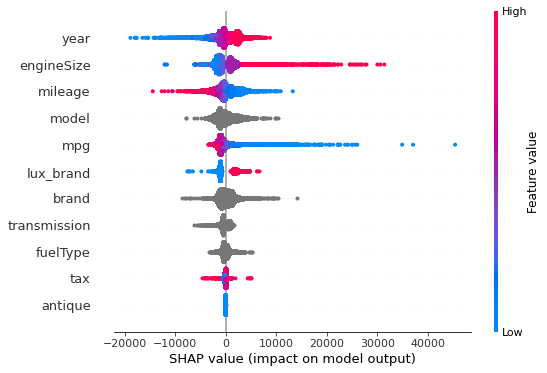

In [11]:
shap.summary_plot(shap_values, features=x_test)

Dengan bantuan graphic beeswarm, kita tidak hanya bisa melihat urutan fitur yang paling signifikan tapi juga bisa melihat arah pengaruhnya terhadap target (price). Apakah fitur tersebut memberikan pengaruh positif (meningkatkan harga) atau negatif (menurunkan harga).

Pada grafik beeswarm diatas kita dapat melihat fitur model, brand, transmission dan fuelType memiliki warna abu-abu. Ini dikarenakan keempat fitur tersebut adalah fitur kategorikal dan masing-masing value pada fitur kategorikal tersebut memiliki daya pengaruh yang berbeda-beda terhadap target sehingga pada grafik beeswarm warnanya menjadi abu-abu.

Berdasarkan informasi sebelumnya dan graphic beeswarm diatas kita dapat mengatakan bahwa:
1. Year yang berukuran kecil (semakin tua umur mobil) memberikan pengaruh negatif terhadap penentuan harga
2. Engine Size yang berukuran besar memberikan pengaruh positif terhadap penentuan harga
3. Nilai mileage yang tinggi akan memberikan pengaruh negatif terhadap penentuan harga
4. Ada lebih banyak jenis model mobil yang memberikan pengaruh positif terhadap penentuan harga
5. MPG yang berukuran kecil memberikan pengaruh positif terhadap penentuan harga
6. Mobil yang bukan dari luxury brand memberikan pengaruh negatif terhadap penentuan harga
7. Ada lebih banyak brand mobil yang memberikan pengaruh positif terhadap penentuan harga
8. Ada lebih banyak jenis transmission mobil yang memberikan pengaruh negatif terhadap penentuan harga
9. Ada lebih banyak jenis bahan bakar mobil yang memberikan pengaruh positif terhadap penentuan harga
10. Tax yang tinggi memberikan pengaruh negatif terhadap penentuan harga
11. Fitur antique tidak memberikan pengaruh yang signifikan

## Scatter Plot

Dengan menggunakan scatterplot, kita dapat melihat efek marginal yang dimiliki tiap fitur dalam memprediksi hasil dari model kita.

**Year**

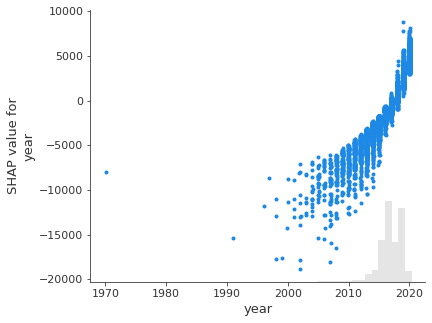

In [12]:
shap.plots.scatter(shap_values[:,'year'])

1. Mobil-mobil yang diregistrasi sebelum tahun 2017-an memiliki pengaruh negatif terhadap price, semakin kecil tahunnya (semakin tua umur mobil) semakin besar pengaruh negatifnya
2. Mobil-mobil yang diregistrasi setelah tahun 2017-an memiliki pengaruh positif terhadap price, semakin besar tahunnya (semakin muda umur mobil) semakin besar pengaruh positifnya

**Engine Size**

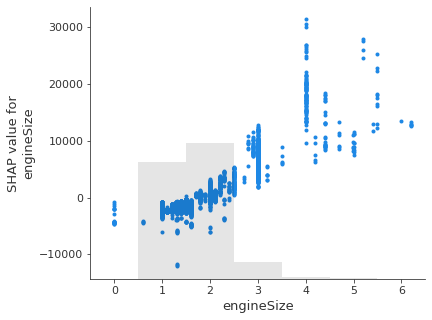

In [13]:
shap.plots.scatter(shap_values[:,'engineSize'])

1. Mobil-mobil yang memiliki engine size dibawah 3 memiliki pengaruh negatif terhadap price, semakin kecil nilai engineSize semakin besar pengaruh negatifnya
2. Mobil-mobil yang memiliki engine size diatas 3 memiliki pengaruh positif terhadap price, semakin besar nilai engineSize semakin besar pengaruh positifnya

**Mileage**

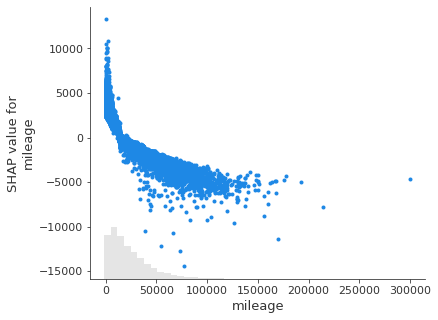

In [14]:
shap.plots.scatter(shap_values[:,'mileage'])

1. Mobil-mobil yang memiliki nilai mileage lebih kecil dari 20000-an memiliki pengaruh positif terhadap price, semakin kecil nilai milage semakin besar pengaruh positifnya
2. mobil-mobil yang memiliki nilai mileage lebih besar dari 20000-an memiliki pengaruh negatif terhadap price, semakin besar nilai mileage semakin besar pengaruh negatifnya

**MPG**

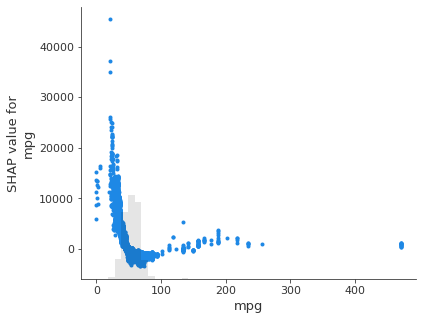

In [15]:
shap.plots.scatter(shap_values[:,'mpg'])

1. Mobil-mobil yang memiliki nilai mpg lebih kecil dari 50-an memiliki pengaruh positif terhadap price, semakin kecil nilai mpg semakin besar pengaruh positifnya
2. Mobil-mobil yang memiliki nilai mpg lebih sari dari 50-an memiliki pengaruh negatif terhadap price, semakin besar nilai mpg semakin besar pengaruh negatifnya

**Luxurious Brand**

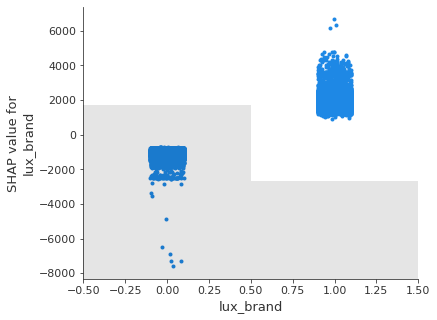

In [16]:
shap.plots.scatter(shap_values[:,'lux_brand'])

1. Mobil-mobil yang bukan dari luxury brand memiliki pengaruh negatif terhadap price
2. Mobil-mobil yang merupakan luxury brand, memiliki pengaruh positif terhadap price

**Tax**

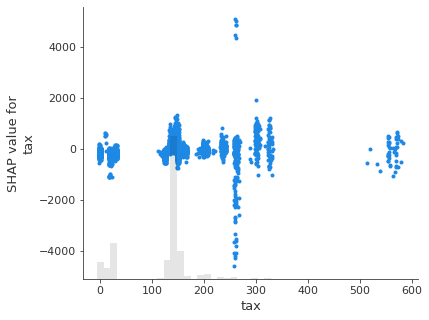

In [17]:
shap.plots.scatter(shap_values[:,'tax'])

1. Pajak kurang lebih memiliki pengaruh yang moderate terdahap price
2. Terdapat banyak mobil yang memiliki pajak diangka 270-an yang memberikan pengaruh negatif terhadap price

## Individual Case Visualization

Dari informasi grafik sebelumnya, kita telah menginterpretasi bagaimana masing-masing fitur dalam model kita secara umum dapat **mempengaruhi** harga mobil. Sekarang kita akan melihat beberapa contoh observasi pada data test, untuk mengetahui bagaimana model kita **menentukan** harga suatu mobil berdasarkan data yang diberikan

### Observasi Data Test ke-0

In [108]:
x_test.iloc[[0]]

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,brand,lux_brand,antique
46841,Fiesta,2017,Manual,11129,Petrol,145.0,65.7,1.0,ford,0,0


In [84]:
# actual price pada observasi 0 (index 46841) di data test
y_test.loc[46841]

10995

In [21]:
shap.plots.force(shap_values[0])

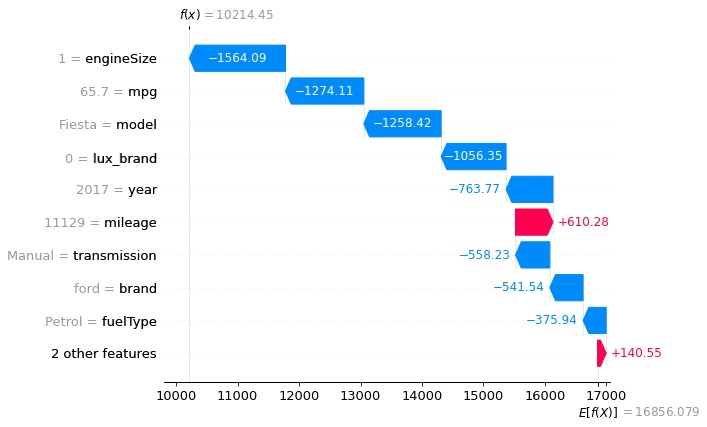

In [22]:
shap.plots.waterfall(shap_values[0])

Dari grafik pertama, kita bisa lihat fitur-fitur apa saja yang memiliki pengaruh besar dalam penentuan harga, dan bagaimana arah pengaruhnya. Pada observasi ini mileage adalah faktor yang paling meningkatkan harga mobil, tetapi ada lebih banyak faktor yang membuat harga mobil menjadi lebih rendah hingga mencapai nilai £10.214,45. Selain itu kita juga akhirnya bisa melihat pengaruh dari fitur-fitur kategorikal, pada contoh ini kita dapat mengetahui bahwa model fiesta, transmission manual, brand ford dan fuel type petrol ternyata memiliki pengaruh negatif terhadap target (harga).

Untuk lebih detailnya kita bisa lihat di grafik kedua, pada dasarnya grafik kedua sama dengan grafik pertama hanya saja dalam bentuk waterfall dan memiliki penjelasan visual yang lebih detail. Disini kita bisa lihat bahwa base value untuk mobil ini adalah £16.856,079. Apakah arti base value didalam SHAP? Singkatnya base value adalah nilai yang akan menjadi nilai prediksi dari model kita jika kita tidak memiliki atau tidak mengetahui fitur-fitur pada data kita. Base value diambil dari nilai rata-rata pada data yang kita miliki, dalam kasus ini adalah nilai rata-rata dari data test.

Base value kemudian dijumlahkan dengan nilai dari fitur-fitur pada mobil tersebut sesuai dengan arah pengaruhnya. Jika arahnya positif nilainya akan ditambahkan ke base value sedangkan jika arahnya negatif nilainya akan mengurangi nilai base valuenya. 

Jadi pada contoh diatas formulanya akan seperti ini : 
nilai_prediksi = base value + (engineSize + mpg + model + lux_brand + year + mileage + transmission + brand + fuelType + tax + antique)

nilai_prediksi = 16.856,079 + (-1564,09 - 1274,11 - 1258,42 - 1056,35 - 763,77 + 610,28 - 558,23 - 541.54 - 375,94 + 140.55)

nilai prediksi = 10.214,459


Dari kedua grafik diatas, model kita memprediksi harga mobil untuk observasi ke-0 sebesar 10.214,45. Sedangkan harga aslinya adalah 10.995, terdapat kesalahan prediksi sebesar 7.09%. Hal ini sejalan dengan nilai MAPE dari data test kita yaitu sebesar 7% secara umum dan 7.03% untuk brand ford.

### Observasi Data Test ke-2

In [109]:
x_test.iloc[[2]]

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,brand,lux_brand,antique
4495,Q3,2019,Automatic,15484,Petrol,145.0,31.7,2.0,audi,1,0


In [110]:
# actual price pada observasi 2 (index 4495) di data test
y_test.loc[4495]

29990

In [106]:
shap.plots.force(shap_values[2])

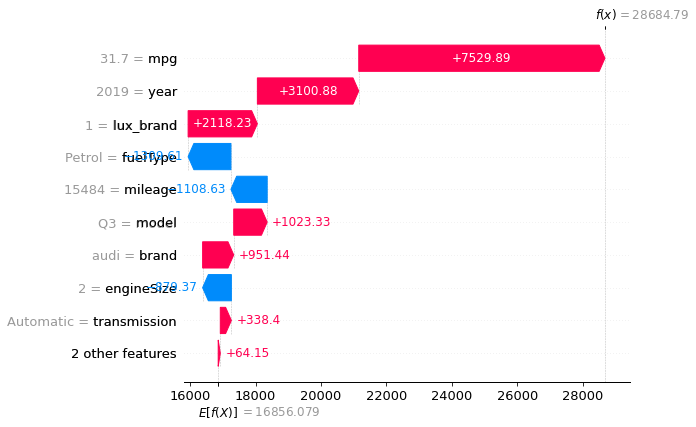

In [111]:
shap.plots.waterfall(shap_values[2])

Sama dengan contoh yang pertama, pada kedua grafik diatas kita bisa melihat fitur-fitur apa saja yang memiliki pengaruh besar dalam penentuan harga. Yang berbeda pada grafik ini adalah, menampilkan fitur-fitur yang lebih banyak meningkatkan harga mobil, sehingga harga mobil menjadi lebih tinggi dibanding contoh sebelumnya. Selain itu kita juga bisa melihat pengaruh dari fitur-fitur kategorikal. Sama dengan contoh sebelumnya, fuel type petrol memiliki pengaruh negatif terhadap target (harga) sedangkan model Q3, brand audi dan transmission automatic memiliki pengaruh positif terhadap harga.

Pada grafik kedua kita bisa melihat bagaimana model kita menentukan hasil prediksi harga mobil tersebut, dengan menggunakan formula yang sama, maka hasilnya akan seperti ini : 

nilai_prediksi = base value + ( mpg + year + lux_brand + fuelType + mileage + model + brand + engineSize + transmission + tax + antique)

nilai_prediksi = 16.856,079 + (7529,89 + 3100,88 + 2118,23 - 1309,61 - 1108,63 + 1023,33 + 951,44 - 879,37 + 338,4 + 64,15)

nilai prediksi = 28.684,789


Dari kedua grafik diatas, model kita memprediksi harga mobil untuk observasi ke-2 sebesar 28.684,79. Sedangkan harga aslinya adalah 29.990, terdapat kesalahan prediksi sebesar 4.35%. Hal ini sejalan dengan nilai MAPE dari data test kita yaitu sebesar 7% secara umum dan 7.14% untuk brand audi.

# Kesimpulan

Kita berhasil membuat model machine learning dengan kesalahan prediksi sebesar 7.16% pada data train dan performanya menjadi lebih baik pada data test dengan kesalahan prediksi sebesar 7%. Jika dibandingkan dengan model benchmark, terdapat peningkatan performa setelah dilakukan feature engineering dan hyperparameter tuning. Berdasarkan hal itu, kita bisa mengatakan penambahan informasi / fitur dapat membantu dalam meningkatkan performa model dalam memprediksi harga mobil. Sehingga model ini bisa memiliki performa yang lebih baik lagi jika mendapatkan tambahan informasi / fitur.

Secara umum model kita mampu memprediksi harga jual mobil dengan kesalahan prediksi sekitar 7%. Dan pada saat ditest berdasarkan brandnya, mobil kita menampilkan performa yang tinggi saat memprediksi mobil-mobil dengan brand toyota dengan kesalahan prediksi sebesar 6.18%

Dengan menggunakan SHAP kita juga dapat menginterpretasi model kita. Tanpa SHAP, kita hanya bisa mendapatkan informasi feature importance (karena model kita menggunakan catboost). Tetapi feature importance hanya menunjukkan besar pengaruh fitur terhadap target. Dengan menggunakan SHAP, kita dapat mengetahui tidak hanya besar pengaruh fitur tersebut, tetapi juga arahnya (positif atau negatif terhadap target), efek marginal tiap fitur, bahkan bagaimana pengaruh fitur-fitur tersebut dapat menentukan harga pada tiap observasi data.